In [10]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import duckdb
from pathlib import Path

DATA = Path("../..").resolve() / "data"
DATA

PosixPath('/home/andy/frequency_model/data')

In [11]:
df = duckdb.sql(f"from read_csv_auto('{DATA.as_posix()}/other_liability_data_clean.csv')").to_df()
df['paid_rpt_ratio'] = df['paid_loss'] / df['reported_loss']
df['loss_ratio'] = df['incurred_loss'] / df['ep']
df['log_loss_ratio'] = df['loss_ratio'].apply(lambda x: np.log(x) if x > 0 else 0)
df['ave__log_loss_ratio'] = df['log_loss_ratio'].mean()
df['std__log_loss_ratio'] = df['log_loss_ratio'].std()
df.head()

,acc_year,dev_lag,incurred_loss,paid_loss,bulk_reserve,ep,case_reserve,reported_loss,paid_rpt_ratio,loss_ratio,log_loss_ratio,ave__log_loss_ratio,std__log_loss_ratio
0,1988,1,295980.0,31447.0,167233.0,508339.0,97300.0,128747.0,0.244254,0.582249,-0.540857,-0.311305,0.113958
1,1988,2,315210.0,87470.0,119272.0,508339.0,108468.0,195938.0,0.446417,0.620078,-0.477909,-0.311305,0.113958
2,1988,3,338804.0,146807.0,97624.0,508339.0,94373.0,241180.0,0.608703,0.666492,-0.405727,-0.311305,0.113958
3,1988,4,363137.0,220502.0,79690.0,508339.0,62945.0,283447.0,0.777930,0.714360,-0.336368,-0.311305,0.113958
4,1988,5,346240.0,256564.0,48838.0,508339.0,40838.0,297402.0,0.862684,0.681120,-0.384016,-0.311305,0.113958


In [15]:
max_ay = df['acc_year'].max()
cur_diagonal = df.loc[df.acc_year + df.dev_lag - 1 == max_ay]
cur_diagonal['log_prem'] = cur_diagonal['ep'].apply(lambda x: np.log(x) if x > 0 else 0)
log_lr = cur_diagonal.set_index('acc_year').log_loss_ratio
log_lr.mean(), log_lr.std()

/tmp/ipykernel_427517/1443430779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_diagonal['log_prem'] = cur_diagonal['ep'].apply(lambda x: np.log(x) if x > 0 else 0)


(-0.29334845607783566, 0.09418288459748496)

In [21]:
def build_triangle(loss_type):
    return df[['acc_year', 'dev_lag', loss_type]].pivot_table(index='acc_year', columns='dev_lag', values=loss_type, aggfunc='sum', fill_value=0)

In [24]:
obs_paid_loss = build_triangle('paid_loss')
obs_reported_loss = build_triangle('reported_loss')
obs_paid_reported_ratio = obs_paid_loss / obs_reported_loss
obs_paid_reported_ratio

dev_lag,1,2,3,4,5,6,7,8,9,10
acc_year,,,,,,,,,,
1988,0.244254,0.446417,0.608703,0.777930,0.862684,0.913528,0.957905,0.973532,0.985683,0.994774
1989,0.270824,0.477940,0.657844,0.784478,0.877218,0.937609,0.961554,0.987470,0.992750,0.995830
1990,0.269259,0.455262,0.640021,0.753023,0.842922,0.917517,0.947078,0.970282,0.971589,0.981416
1991,0.257101,0.476279,0.637280,0.790779,0.871846,0.908923,0.924838,0.942257,0.945659,0.993673
1992,0.261401,0.471546,0.640791,0.798164,0.826233,0.862659,0.894719,0.921615,0.986404,0.983338
1993,0.239300,0.482652,0.679259,0.794069,0.861945,0.895525,0.934660,0.964712,0.969958,0.980173
1994,0.257624,0.481686,0.608678,0.691617,0.775309,0.828055,0.959748,0.961569,0.983480,0.987580
1995,0.186637,0.477876,0.662504,0.800931,0.875565,0.918888,0.941737,0.959520,0.974795,0.983313
1996,0.264081,0.504656,0.675077,0.810844,0.894867,0.933532,0.960644,0.974442,0.981104,0.983264


In [ ]:
def triangle_of_prior_betas(triangle):
    n_acc, n_dev = triangle.shape
    for i in range(n_dev):
    return [
        triangle.iloc[:(n_acc - i - 1), i+1].sum() / triangle.iloc[:(n_acc - i - 1), i].sum()
        for i in range(n_dev)
    ]

In [32]:
N_YEARS = df.acc_year.nunique()
N_PERIODS = df.dev_lag.nunique()

BETA_PRIOR_MU = 0.5
BETA_PRIOR_SIGMA = 5

# Build the PyMC model
with pm.Model() as model:
    # Priors for log expected loss ratio by accident year and derived ultimate loss
    log_elr = pm.Normal('log_elr', mu=log_lr.mean(), sigma=log_lr.std(), shape=(N_YEARS, 1))
    log_premium = cur_diagonal['log_prem'].to_numpy()
    log_ultimate =  log_premium + log_elr

    # Expected ultimate loss by accident year is the sampled ELR times the premium
    # This is the ultimate loss for each accident year, and is the same for both paid and 
    # reported losses
    expected_ultimate_loss = pm.Deterministic('expected_ultimate_loss', pm.math.exp(log_ultimate))
    
    # At ultimate, the ratio of paid to incurred is 1 by definition
    expected_ultimate_paid_rpt_ratio = 1

    # Beta parameters represent the percent of ultimate loss paid or
    # reported through each development period, or for the ratio of
    # paid to incurred. This is generally a percentage between 0 and 1,
    # but can be greater than 1 if case reserves exceed the actual unpaid loss,
    # so we use a normal distribution with a mean of 0.5 and a fairly
    # wide standard deviation to allow for this possibility.
    beta_paid = pm.Normal('beta_paid', mu=BETA_PRIOR_MU, sigma=BETA_PRIOR_SIGMA, shape=(1,N_PERIODS))
    beta_rpt = pm.Normal('beta_rpt', mu=BETA_PRIOR_MU, sigma=BETA_PRIOR_SIGMA, shape=(1,N_PERIODS))
    beta_ratio = pm.Normal('beta_ratio', mu=BETA_PRIOR_MU, sigma=BETA_PRIOR_SIGMA, shape=(1,N_PERIODS))
    
    # Expected loss for each cell in the triangle, for paid, reported, and the ratio
    # is the product of the expected ultimate loss and the beta parameter for that cell
    # and loss type
    expected_paid_loss = expected_ultimate_loss * beta_paid
    expected_rpt_loss = expected_ultimate_loss * beta_rpt
    expected_paid_rpt_ratio = expected_ultimate_paid_rpt_ratio * beta_ratio
    
    # Observation noise (standard deviations)
    sigma_paid = pm.HalfNormal('sigma_paid', sigma=1000, shape=(N_YEARS, N_PERIODS))
    sigma_rpt = pm.HalfNormal('sigma_rpt', sigma=1000, shape=(N_YEARS, N_PERIODS))
    sigma_ratio = pm.HalfNormal('sigma_ratio', sigma=0.1, shape=(N_YEARS, N_PERIODS))
    
    # Observed data likelihood
    paid_obs = pm.Normal('paid_obs', mu=expected_paid_loss, sigma=sigma_paid, observed=obs_paid_loss)
    rpt_obs = pm.Normal('rpt_obs', mu=expected_rpt_loss, sigma=sigma_rpt, observed=obs_reported_loss)
    ratio_obs = pm.Normal('ratio_obs', mu=expected_paid_rpt_ratio, sigma=sigma_ratio, observed=obs_paid_reported_ratio)
    
    # Sampling from the posterior
    trace = pm.sample(2000, tune=2000, target_accept=0.95, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_elr, beta_paid, beta_rpt, beta_ratio, sigma_paid, sigma_rpt, sigma_ratio]


Output()

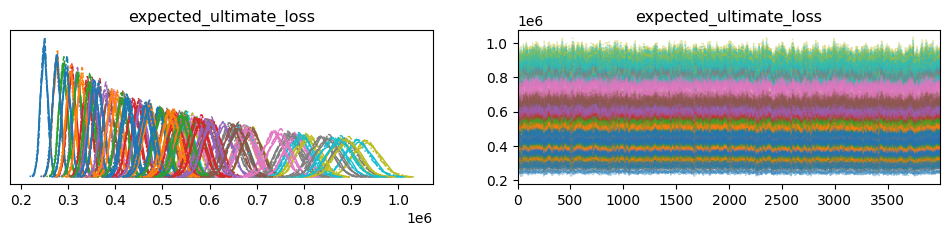

In [29]:
# Posterior analysis
az.plot_trace(trace, var_names=['expected_ultimate_loss'])
plt.show()

In [30]:
az.summary(trace, var_names=['expected_ultimate_loss'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"expected_ultimate_loss[0, 0]",249094.609,7842.990,234537.771,264239.819,263.337,186.380,891.0,2039.0,1.01
"expected_ultimate_loss[0, 1]",275914.694,8687.447,259790.517,292690.593,291.690,206.448,891.0,2039.0,1.01
"expected_ultimate_loss[0, 2]",289646.433,9119.804,272719.787,307257.235,306.207,216.722,891.0,2039.0,1.01
"expected_ultimate_loss[0, 3]",307121.899,9670.037,289174.005,325795.228,324.682,229.798,891.0,2039.0,1.01
"expected_ultimate_loss[0, 4]",318180.597,10018.231,299586.443,337526.305,336.373,238.072,891.0,2039.0,1.01
...,...,...,...,...,...,...,...,...,...
"expected_ultimate_loss[9, 5]",659938.492,20392.033,621953.214,699144.577,691.042,488.935,871.0,1905.0,1.01
"expected_ultimate_loss[9, 6]",748879.352,23140.297,705774.744,793369.298,784.175,554.829,871.0,1905.0,1.01
"expected_ultimate_loss[9, 7]",850853.809,26291.297,801879.672,901401.925,890.956,630.380,871.0,1905.0,1.01
"expected_ultimate_loss[9, 8]",892433.394,27576.102,841065.986,945451.699,934.495,661.185,871.0,1905.0,1.01
